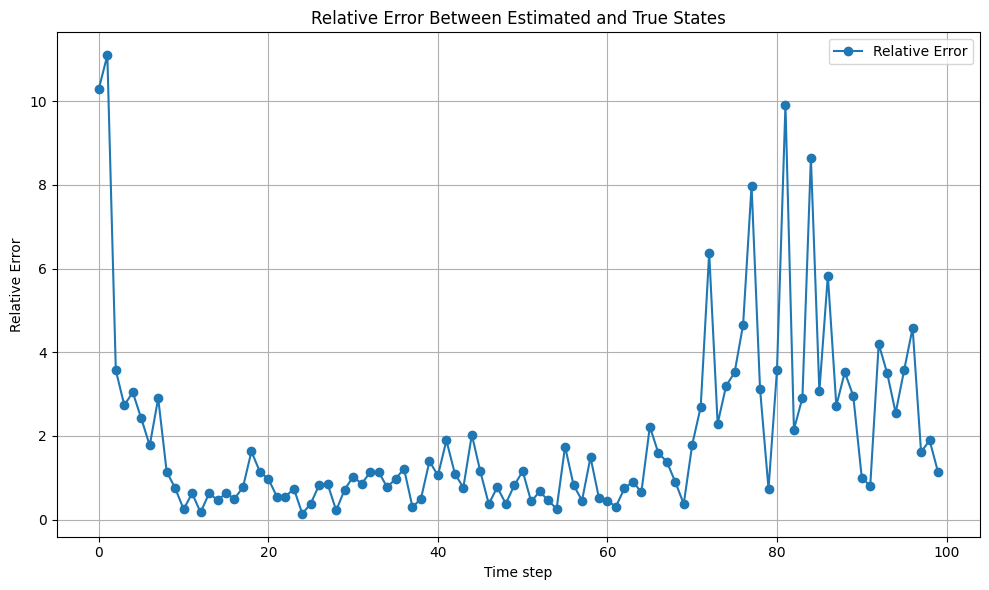

In [113]:
import numpy as np
import matplotlib.pyplot as plt

class AdaptiveKalmanFilter:
    def __init__(self, state_dim, obs_dim, lambda_rls=0.99):
        self.state_dim = state_dim
        self.obs_dim = obs_dim
        self.lambda_rls = lambda_rls

        # Инициализация переменных фильтра Калмана
        self.x = np.zeros((state_dim, 1))  # Состояние
        self.P = np.eye(state_dim)  # Ковариация состояния
        self.Q = np.eye(state_dim) * 1e-3  # Начальная ковариация процесса
        self.R = np.eye(obs_dim) * 1e-2  # Начальная ковариация измерений

    def predict(self, A, B, u):
        """
        Шаг предсказания фильтра Калмана
        """
        self.x = A @ self.x + B @ u
        self.P = A @ self.P @ A.T + self.Q

    def update(self, z, H):
        """
        Шаг обновления фильтра Калмана
        """
        # Вычисление Калмановского коэффициента
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)

        # Обновление оценки состояния
        e = z - H @ self.x  # Ошибка наблюдения
        self.x = self.x + K @ e

        # Обновление ковариации состояния
        I = np.eye(self.state_dim)
        self.P = (I - K @ H) @ self.P

        # RLS обновление ковариаций
        self.Q = self.lambda_rls * self.Q + (1 - self.lambda_rls) * (e @ e.T)
        self.R = self.lambda_rls * self.R + (1 - self.lambda_rls) * (z - H @ self.x) @ (z - H @ self.x).T

    def run(self, A, B, H, u, z):
        """
        Полный шаг предсказания и обновления
        """
        self.predict(A, B, u)
        self.update(z, H)
        return self.x

# Основной код
if __name__ == "__main__":
    # Инициализация фильтра для 2D состояния и 2D наблюдений
    state_dim = 2
    obs_dim = 2
    kf = AdaptiveKalmanFilter(state_dim, obs_dim)

    # Генерация тестовых данных
    A = np.eye(2)  # Система без изменений
    B = np.zeros((2, 2))  # Без управления
    H = np.eye(2)  # Полное наблюдение
    u = np.zeros((2, 1))  # Нулевое управление

    # Генерация сигналов
    np.random.seed(42)
    true_states = []
    measurements = []
    estimated_states = []

    true_state = np.array([[0], [0]])
    for t in range(100):
        true_state = A @ true_state + np.random.multivariate_normal([0, 0], np.eye(2) * 0.1).reshape(-1, 1)
        z = H @ true_state + np.random.multivariate_normal([0, 0], np.eye(2) * 1.05).reshape(-1, 1)
        measurements.append(z)
        true_states.append(true_state)

        # Применение адаптивного фильтра Калмана
        estimate = kf.run(A, B, H, u, z)
        estimated_states.append(estimate)

    # Преобразование списков в массивы для удобства вычислений
    true_states = np.array(true_states).squeeze()
    estimated_states = np.array(estimated_states).squeeze()

    # Вычисление относительной погрешности
    relative_errors = np.linalg.norm(estimated_states - true_states, axis=1) / np.linalg.norm(true_states, axis=1)

    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(relative_errors, label="Relative Error", marker='o')
    plt.xlabel("Time step")
    plt.ylabel("Relative Error")
    plt.title("Relative Error Between Estimated and True States")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


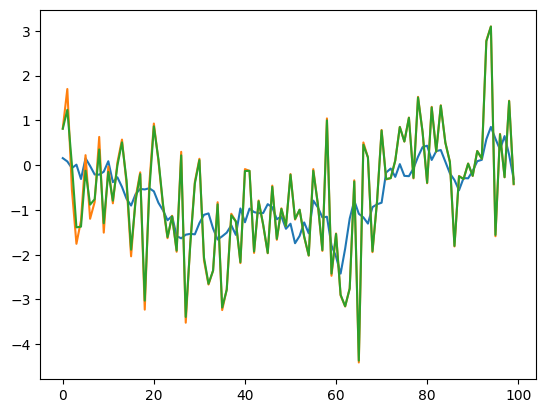

In [114]:
true_states = np.array(true_states).squeeze()
measurements = np.array(measurements).squeeze()
estimated_states = np.array(estimated_states).squeeze()

plt.plot(true_states[:, 0])
plt.plot(measurements[:, 0])
plt.plot(estimated_states[:, 0])


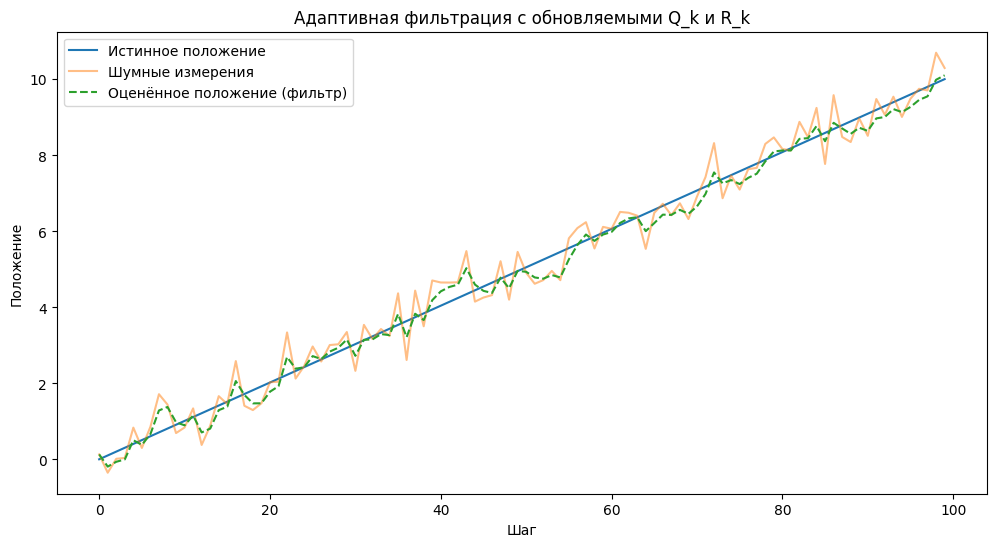

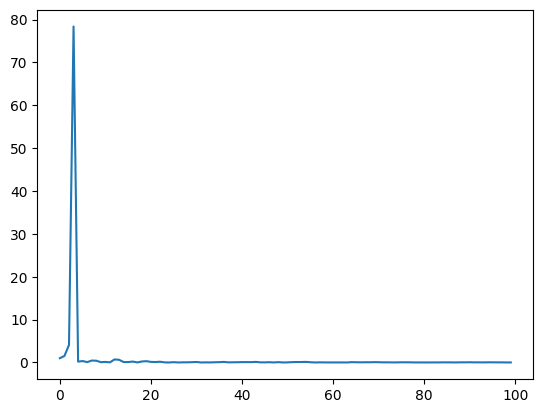

In [131]:
import numpy as np

# Задаём параметры задачи
n_steps = 100  # Количество шагов
true_position = np.linspace(0, 10, n_steps)  # Истинное положение объекта
measurement_noise_std = 0.5  # Стандартное отклонение шума измерений
process_noise_std = 0.5  # Стандартное отклонение шума системы

# Генерируем данные
np.random.seed(43)
measurements = true_position + np.random.normal(0, measurement_noise_std, size=n_steps)

# Инициализация
x_hat = np.zeros(n_steps)  # Оценка состояния
x_hat[0] = measurements[0]  # Начальная оценка
P = 1.0  # Начальная ковариация оценки
Q_k = 1.0  # Инициализация Q_k (ковариация шума системы)
R_k = 1.0  # Инициализация R_k (ковариация шума измерений)
Phi = 1.0  # Модель динамики
H = 1.0  # Модель измерений
alpha = 0.01

# Массивы для хранения адаптивных Q_k и R_k
Q_adaptive = []
R_adaptive = []

# Рекурсивный процесс фильтрации
for k in range(1, n_steps):
    # Экстраполяция
    x_pred = Phi * x_hat[k - 1]  # Предсказание состояния
    P_pred = Phi * P * Phi + Q_k  # Предсказание ковариации

    # Инновация
    innovation = measurements[k] - H * x_pred
    S = H * P_pred * H + R_k  # Ковариация инновации

    # Матрица Калмана
    K = P_pred * H / S

    # Обновление состояния
    x_hat[k] = x_pred + K * innovation
    P = (1 - K * H) * P_pred

    # Адаптивное обновление Q_k и R_k
    Q_k = alpha * (innovation ** 2) + (1.0-alpha) * Q_k  # Упрощённое обновление Q_k
    R_k = alpha * S + (1.0-alpha) * R_k  # Упрощённое обновление R_k

    Q_adaptive.append(Q_k)
    R_adaptive.append(R_k)


relative_errors = np.abs(true_position - x_hat)/np.abs(x_hat)

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(true_position, label="Истинное положение")
plt.plot(measurements, label="Шумные измерения", alpha=0.5)
plt.plot(x_hat, label="Оценённое положение (фильтр)", linestyle="--")
plt.legend()
plt.xlabel("Шаг")
plt.ylabel("Положение")
plt.title("Адаптивная фильтрация с обновляемыми Q_k и R_k")
plt.show()

plt.plot(relative_errors, label = "Ошибка истенного и оцененного")
plt.show()

